<table align="left">
  <td>
    <a href="https://colab.research.google.com/drive/1dHaUxoXThDiqB_p77QkXtu-vOiKZwCr_#scrollTo=abwRFDn5YMVf" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>

</table>

In [ ]:
"""
Google Colab Setup Cell
Add this at the beginning of your notebook
"""

# ============================================
# GOOGLE COLAB SETUP
# ============================================

print("Setting up environment for BERT fine-tuning...")

# 1. Check GPU availability
import torch
print("\n" + "="*50)
print("GPU INFORMATION")
print("="*50)
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ WARNING: No GPU detected. Training will be slow.")
    print("Enable GPU: Runtime → Change runtime type → Hardware accelerator → GPU")

# 2. Create directory structure
print("\n" + "="*50)
print("CREATING DIRECTORIES")
print("="*50)

import os

directories = [
    '/content/notebooks',
    '/content/reports',
    '/content/output',
    '/content/checkpoints',
    '/content/logs'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)
    print(f"✓ Created: {directory}")

# 3. Install required packages
print("\n" + "="*50)
print("INSTALLING PACKAGES")
print("="*50)
print("This may take 1-2 minutes...\n")

!pip install -q transformers datasets torch accelerate tensorboard scikit-learn

print("✓ All packages installed successfully!")

# 4. Verify installations
print("\n" + "="*50)
print("VERIFYING INSTALLATIONS")
print("="*50)

import transformers
import datasets
import sklearn

print(f"✓ Transformers version: {transformers.__version__}")
print(f"✓ Datasets version: {datasets.__version__}")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ Scikit-learn version: {sklearn.__version__}")

# 5. Mount Google Drive (optional)
print("\n" + "="*50)
print("GOOGLE DRIVE MOUNT (OPTIONAL)")
print("="*50)

mount_drive = True  # Set to True to mount Google Drive

if mount_drive:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✓ Google Drive mounted at /content/drive")
    print("  You can save models to /content/drive/MyDrive/")

    PROJECT_ROOT = '/content/drive/MyDrive/finetuning-nli'

    REPORTS_DIR = f'{PROJECT_ROOT}/reports'
    OUTPUT_DIR = '/content/output'              # fast temp storage
    CHECKPOINT_DIR = f'{PROJECT_ROOT}/checkpoints'

    import os
    os.makedirs(PROJECT_ROOT, exist_ok=True)
    os.makedirs(REPORTS_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
else:
    print("Google Drive not mounted (set mount_drive=True to enable)")

print("\n" + "="*50)
print("SETUP COMPLETE! 🚀")
print("="*50)
print("\nYou can now proceed with the training notebook.")
print("All outputs will be saved to /content/ directories.")

## 1. Setup and Installation

In [2]:
!pip install -q transformers datasets torch accelerate tensorboard evaluate

# Imports and setup
import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, random
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
import evaluate
from tqdm.auto import tqdm
import os

In [3]:
# Set seed
def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
set_seed(42)

In [4]:
print(f"GPU: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")

GPU: False


## 2. Load and Explore Dataset

In [5]:
dataset = load_dataset("rajpurkar/squad")
print(f"Train: {len(dataset['train'])}, Val: {len(dataset['validation'])}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Train: 87599, Val: 10570


In [6]:
# Show examples
for i in range(2):
    ex = dataset['train'][i]
    print(f"\nQ: {ex['question']}\nA: {ex['answers']['text'][0]}")


Q: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
A: Saint Bernadette Soubirous

Q: What is in front of the Notre Dame Main Building?
A: a copper statue of Christ


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.DataFrame(dataset["train"])

# Extract text fields
train_df["context_len"] = train_df["context"].apply(lambda x: len(x.split()))
train_df["question_len"] = train_df["question"].apply(lambda x: len(x.split()))
train_df["answer_len"] = train_df["answers"].apply(lambda x: len(x["text"][0].split()) if len(x["text"]) > 0 else 0)
train_df["answer_start"] = train_df["answers"].apply(lambda x: x["answer_start"][0] if len(x["answer_start"]) > 0 else -1)
train_df["context_char_len"] = train_df["context"].apply(len)


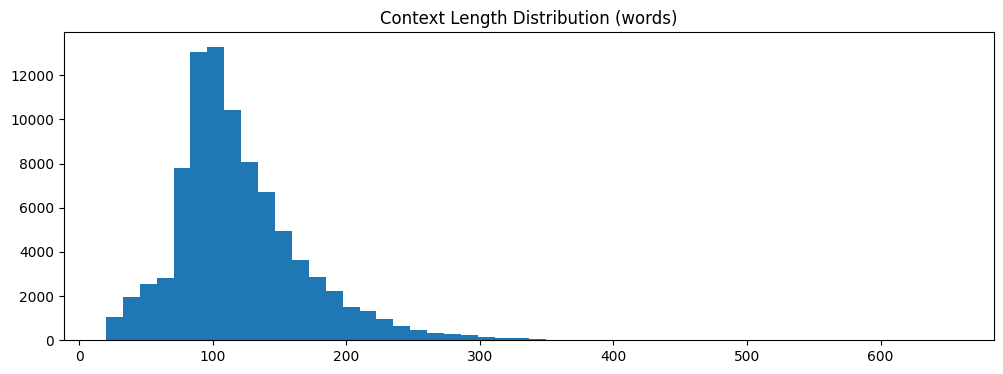

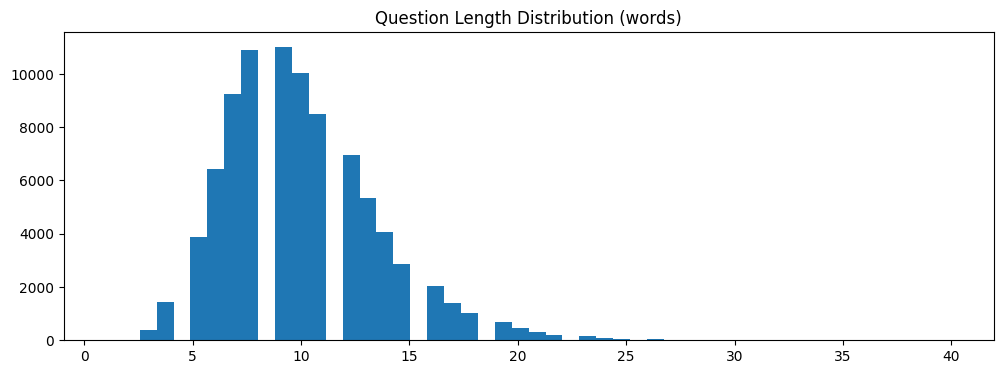

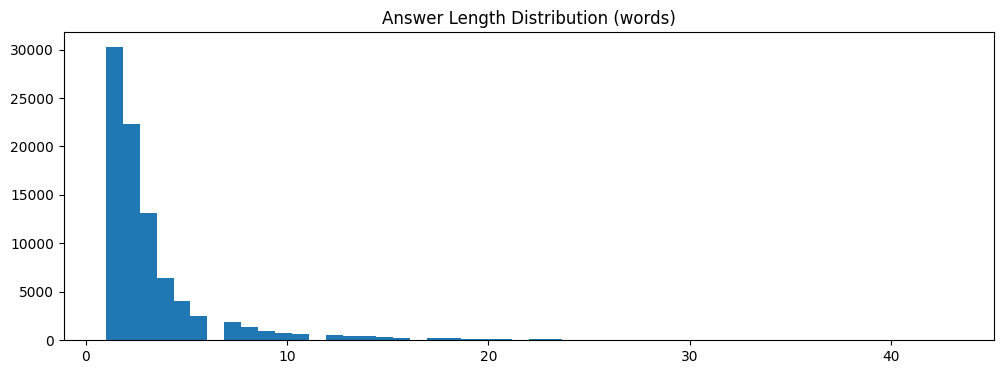

In [8]:
plt.figure(figsize=(12,4))
plt.hist(train_df["context_len"], bins=50)
plt.title("Context Length Distribution (words)")
plt.show()

plt.figure(figsize=(12,4))
plt.hist(train_df["question_len"], bins=50)
plt.title("Question Length Distribution (words)")
plt.show()

plt.figure(figsize=(12,4))
plt.hist(train_df["answer_len"], bins=50)
plt.title("Answer Length Distribution (words)")
plt.show()


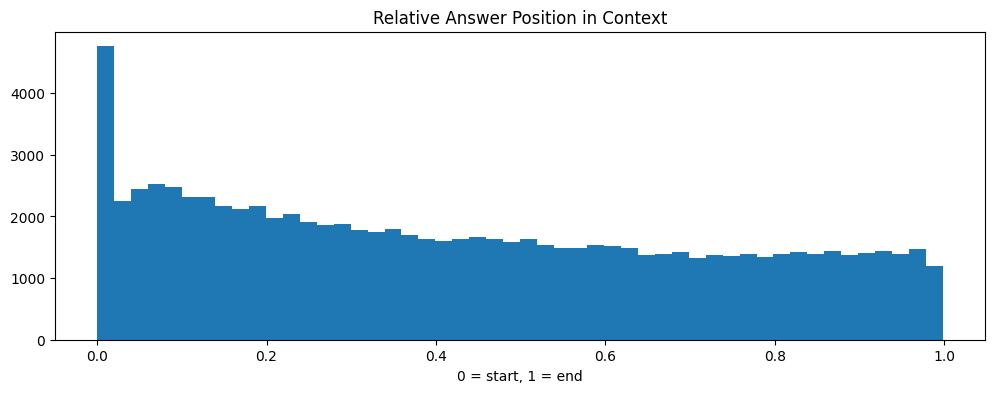

In [9]:
train_df["answer_pos_ratio"] = train_df["answer_start"] / train_df["context_char_len"]

plt.figure(figsize=(12,4))
plt.hist(train_df["answer_pos_ratio"], bins=50)
plt.title("Relative Answer Position in Context")
plt.xlabel("0 = start, 1 = end")
plt.show()


In [10]:
train_df[["context_len", "question_len", "answer_len"]].corr()


,context_len,question_len,answer_len
context_len,1.000000,0.016081,0.028785
question_len,0.016081,1.000000,-0.043472
answer_len,0.028785,-0.043472,1.000000


In [11]:
train_df.sort_values("context_len", ascending=False).head(3)[["context_len","question","context"]]
train_df.sort_values("answer_len", ascending=False).head(3)[["answer_len","question","answers"]]


,answer_len,question,answers
3583,43,What was concluded about the construction?,{'text': ['that the sudden shift of a huge qua...
44993,31,What states border Florida,"{'text': ['to the west by the Gulf of Mexico, ..."
77839,30,Where can the third lion be seen?,{'text': ['the third is symbolised by the capt...


## 3. Tokenization and Preprocessing

In [12]:
MODEL_NAME = "t5-base"
MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 32
BATCH_SIZE = 8
LEARNING_RATE = 3e-4
NUM_EPOCHS = 3
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [13]:
def preprocess_function(examples):
    inputs = [f"question: {q} context: {c}" for q, c in zip(examples['question'], examples['context'])]
    model_inputs = tokenizer(inputs, max_length=MAX_INPUT_LENGTH, truncation=True)

    targets = [ans["text"][0] if len(ans["text"]) > 0 else "" for ans in examples["answers"]]
    labels = tokenizer(targets, max_length=MAX_TARGET_LENGTH, truncation=True)

    labels_ids = labels["input_ids"]
    labels_ids = [[(tok if tok != tokenizer.pad_token_id else -100) for tok in seq] for seq in labels_ids]

    model_inputs["labels"] = labels_ids
    return model_inputs

In [14]:
print("Preprocessing...")
tokenized_datasets = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)
print("Done!")

Preprocessing...


Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

Done!


## 4. Model Training

In [15]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
print(f"Parameters: {model.num_parameters():,}")

squad_metric = evaluate.load("squad")

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Parameters: 222,903,552


In [16]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    formatted_preds = [{"id": str(i), "prediction_text": p.strip()} for i, p in enumerate(decoded_preds)]
    formatted_refs = [{"id": str(i), "answers": {"text": [l.strip()], "answer_start": [0]}} for i, l in enumerate(decoded_labels)]

    result = squad_metric.compute(predictions=formatted_preds, references=formatted_refs)
    return {'exact_match': result['exact_match'], 'f1': result['f1']}

In [17]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/output",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps=2000,
    save_steps=2000,
    logging_steps=500,
    predict_with_generate=True,
    generation_max_length=MAX_TARGET_LENGTH,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    warmup_steps=500,
    fp16=torch.cuda.is_available(),
    save_total_limit=2,
    report_to="tensorboard",
    logging_dir="/content/logs",
    seed=42,
)

In [18]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, padding=True)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-2281741434.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
print("\nStarting training (60-90 min on T4)...")
train_result = trainer.train()
print(f"Training loss: {train_result.training_loss:.4f}")


Starting training (60-90 min on T4)...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss


In [ ]:
trainer.save_model(CHECKPOINT_DIR)
tokenizer.save_pretrained(CHECKPOINT_DIR)

## 5. Model Evaluation

In [ ]:
eval_results = trainer.evaluate()
print(f"\nExact Match: {eval_results['eval_exact_match']:.2f}")
print(f"F1 Score: {eval_results['eval_f1']:.2f}")

In [ ]:
results_df = pd.DataFrame([{
    'Model': MODEL_NAME,
    'Exact Match': eval_results['eval_exact_match'],
    'F1 Score': eval_results['eval_f1']
}])
results_df.to_csv('/content/reports/training_results.csv', index=False)

In [ ]:
class T5QA:
    def __init__(self, path):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = T5ForConditionalGeneration.from_pretrained(path).to(self.device).eval()
        self.tokenizer = T5Tokenizer.from_pretrained(path)

    def answer(self, question, context):
        input_text = f"question: {question} context: {context}"
        input_ids = self.tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).input_ids.to(self.device)
        with torch.no_grad():
            outputs = self.model.generate(input_ids, max_length=32, num_beams=4, early_stopping=True)
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

qa = T5QA(CHECKPOINT_DIR)


In [ ]:
examples = [
    ("What is the capital of France?", "Paris is the capital of France with 2.2 million people."),
    ("When was the Eiffel Tower built?", "The Eiffel Tower was built between 1887 and 1889 for the World's Fair.")
]

for q, c in examples:
    print(f"Q: {q}\nA: {qa.answer(q, c)}\n")

In [ ]:
!zip -r /content/t5_qa_model.zip /content/checkpoints/